In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as feature

### Get data!

In [2]:
path = '/home/cshu2/clim680/'
fname = 'newPM_202207.nc'
ds = xr.open_dataset(path+fname)
ds

<xarray.Dataset>
Dimensions:  (day: 31, time: 24, lat: 351, lon: 801)
Coordinates:
  * day      (day) int32 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
  * time     (time) int32 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
  * lat      (lat) float32 15.0 15.1 15.2 15.3 15.4 ... 49.6 49.7 49.8 49.9 50.0
  * lon      (lon) float32 -130.0 -129.9 -129.8 -129.7 ... -50.2 -50.1 -50.0
Data variables:
    PM10     (day, time, lat, lon) float32 ...
    PM25     (day, time, lat, lon) float32 ...

### Define functions to do basic plotting settings and xticks/yticks

In [3]:
def plot_setting(ax, lon1, lon2, lat1, lat2):
    # Choose lat/lon ranges
    ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())
    
    # Add coastlines and stateslines
    ax.coastlines()
    ax.add_feature(cfeature.STATES.with_scale('110m'))

    # Add gridlines
    ax.gridlines()
    
    return

In [4]:
def xyticks(ax, lons, lats):
    # Define the xticks for longitude
    ax.set_xticks(lons, crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    ax.set_yticks(lats, crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter) 
    
    return

### Use groupby to calculate diurnal mean of monthly data ("climatology")

In [5]:
ds_climo = ds.groupby('time').mean('day')
ds_climo

<xarray.Dataset>
Dimensions:  (time: 24, lat: 351, lon: 801)
Coordinates:
  * time     (time) int32 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
  * lat      (lat) float32 15.0 15.1 15.2 15.3 15.4 ... 49.6 49.7 49.8 49.9 50.0
  * lon      (lon) float32 -130.0 -129.9 -129.8 -129.7 ... -50.2 -50.1 -50.0
Data variables:
    PM10     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    PM25     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

### Use groupby to calculate monthly mean

In [6]:
ds_daily = ds_climo.groupby('lat').mean('time')
ds_daily

<xarray.Dataset>
Dimensions:  (lat: 351, lon: 801)
Coordinates:
  * lat      (lat) float32 15.0 15.1 15.2 15.3 15.4 ... 49.6 49.7 49.8 49.9 50.0
  * lon      (lon) float32 -130.0 -129.9 -129.8 -129.7 ... -50.2 -50.1 -50.0
Data variables:
    PM10     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    PM25     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

### Set colorbar

In [7]:
import matplotlib.colors as colors
import cartopy.feature as cfeature
import matplotlib

# Make the figure larger
fig = plt.figure(figsize=(11,6.5))

from matplotlib.cm import ScalarMappable

clevs = [0,4,8,12,16,20,30,40,60,80,100,200,500,1000]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=13)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))



<Figure size 1100x650 with 0 Axes>

Text(0.5, 0.98, 'CMAQ-output PM10 202207 monthly diurnal mean')

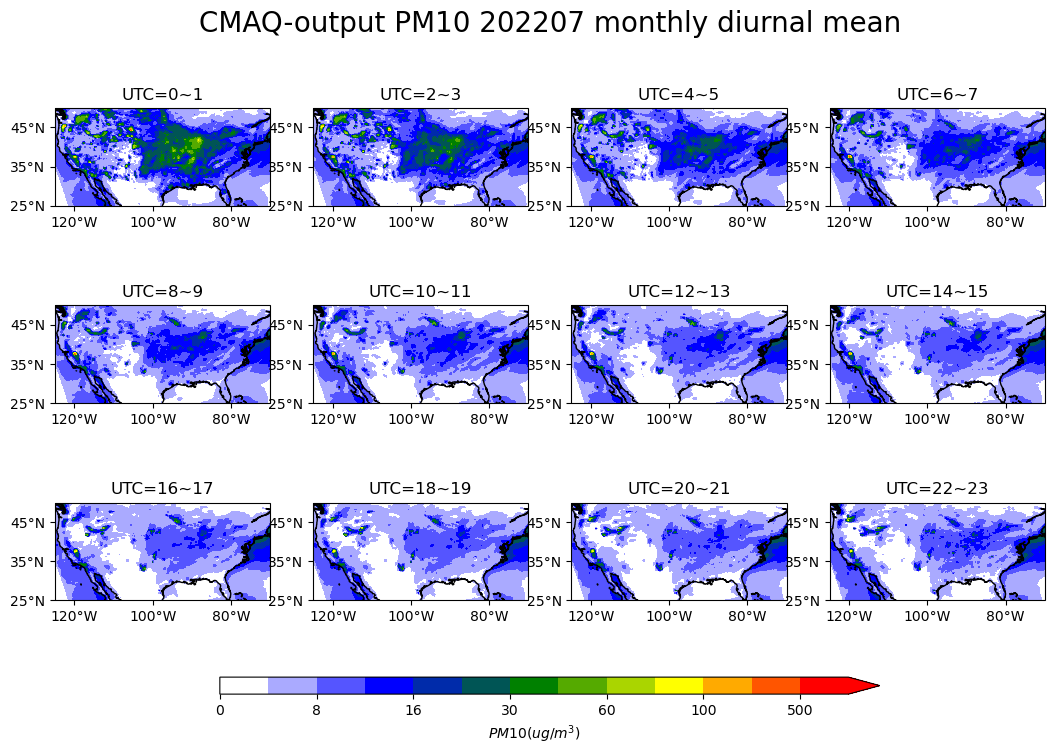

In [8]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=3,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i in range(0,12,1):

        # Contour plot
        cs=axs[i].contourf(            
            ds_climo['lon'], 
            ds_climo['lat'], 
            (ds_climo['PM10'][i,:,:]+ds_climo['PM10'][i+1,:,:])/2,
            clevs,
            cmap = colormap,
            norm = norm,
            extend='max',
            transform = ccrs.PlateCarree(),
        )
        # Choose lat/lon ranges
        axs[i].set_extent([-125,-70,25,50],crs=ccrs.PlateCarree())
       # Longitude labels
        axs[i].set_xticks(np.arange(-120,-69,20), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(25,51,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the time
        title = f"UTC={2*i}~{2*i+1}"
        axs[i].set_title(title)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25) #width and height

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$PM10 (ug/m^{3})$')

# Add a big title at the top
plt.suptitle('CMAQ-output PM10 202207 monthly diurnal mean',fontsize=20)

Text(0.5, 0.98, 'CMAQ-output PM25 202207 monthly diurnal mean')

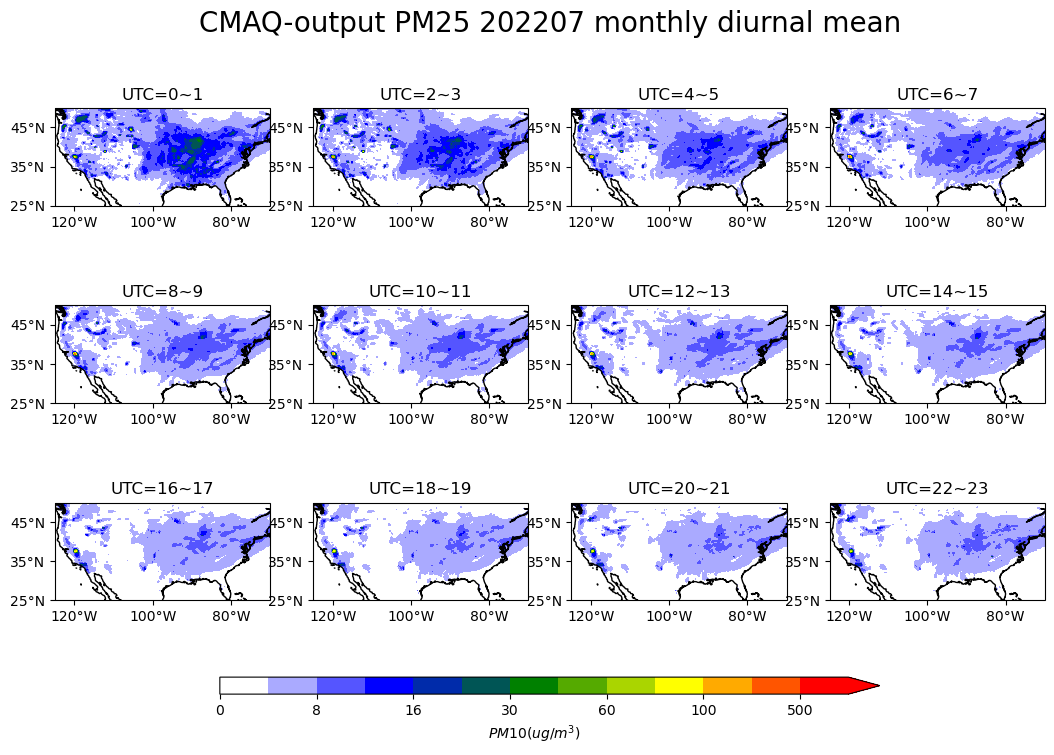

In [9]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=3,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i in range(0,12,1):

        # Contour plot
        cs=axs[i].contourf(            
            ds_climo['lon'], 
            ds_climo['lat'], 
            (ds_climo['PM25'][i,:,:]+ds_climo['PM25'][i+1,:,:])/2,
            clevs,
            cmap = colormap,
            norm = norm,
            extend='max',
            transform = ccrs.PlateCarree(),
        )
        # Choose lat/lon ranges
        axs[i].set_extent([-125,-70,25,50],crs=ccrs.PlateCarree())
       # Longitude labels
        axs[i].set_xticks(np.arange(-120,-69,20), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(25,51,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the time
        title = f"UTC={2*i}~{2*i+1}"
        axs[i].set_title(title)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25) #width and height

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$PM10 (ug/m^{3})$')

# Add a big title at the top
plt.suptitle('CMAQ-output PM25 202207 monthly diurnal mean',fontsize=20)

Text(0.5, 0.98, 'CMAQ-output PM2.5/PM10 ratio 202207 monthly diurnal mean')

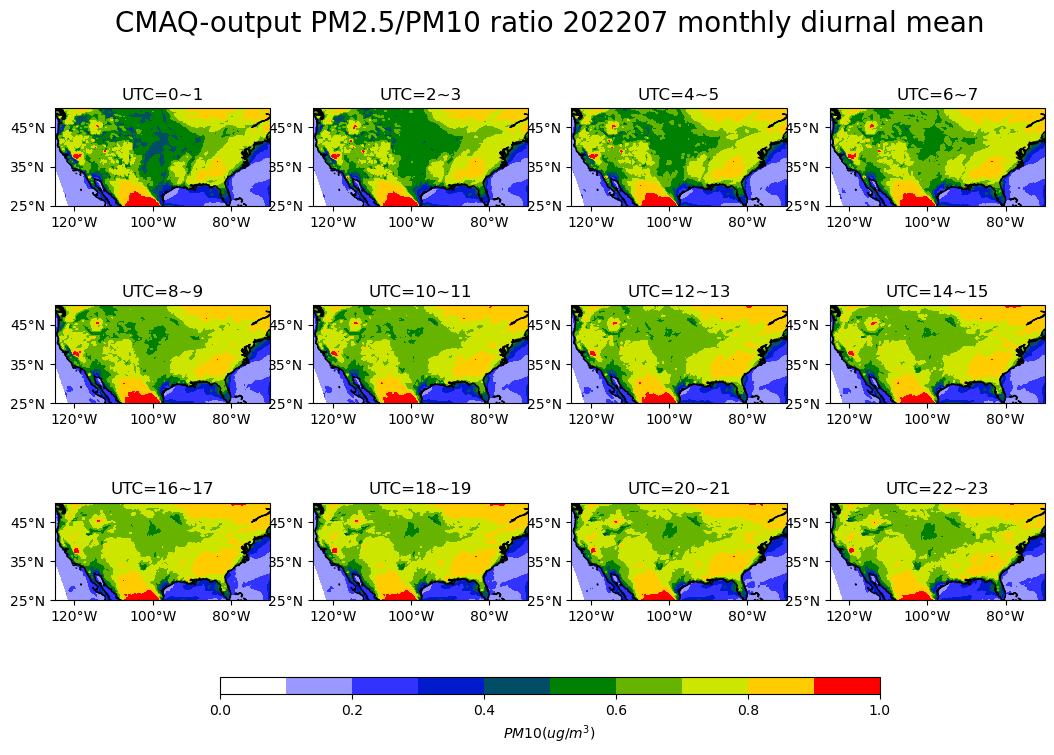

In [10]:
clevs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=11)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))

# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=3,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i in range(0,12,1):

        # Contour plot
        cs=axs[i].contourf(            
            ds_climo['lon'], 
            ds_climo['lat'], 
            (ds_climo['PM25'][i,:,:]+ds_climo['PM25'][i+1,:,:])/(ds_climo['PM10'][i,:,:]+ds_climo['PM10'][i+1,:,:]),
            clevs,
            cmap = colormap,
            norm = norm,
            #extend='max',
            transform = ccrs.PlateCarree(),
        )
        # Choose lat/lon ranges
        axs[i].set_extent([-125,-70,25,50],crs=ccrs.PlateCarree())
       # Longitude labels
        axs[i].set_xticks(np.arange(-120,-69,20), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(25,51,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the time
        title = f"UTC={2*i}~{2*i+1}"
        axs[i].set_title(title)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25) #width and height

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$PM10 (ug/m^{3})$')

# Add a big title at the top
plt.suptitle('CMAQ-output PM2.5/PM10 ratio 202207 monthly diurnal mean',fontsize=20)

''

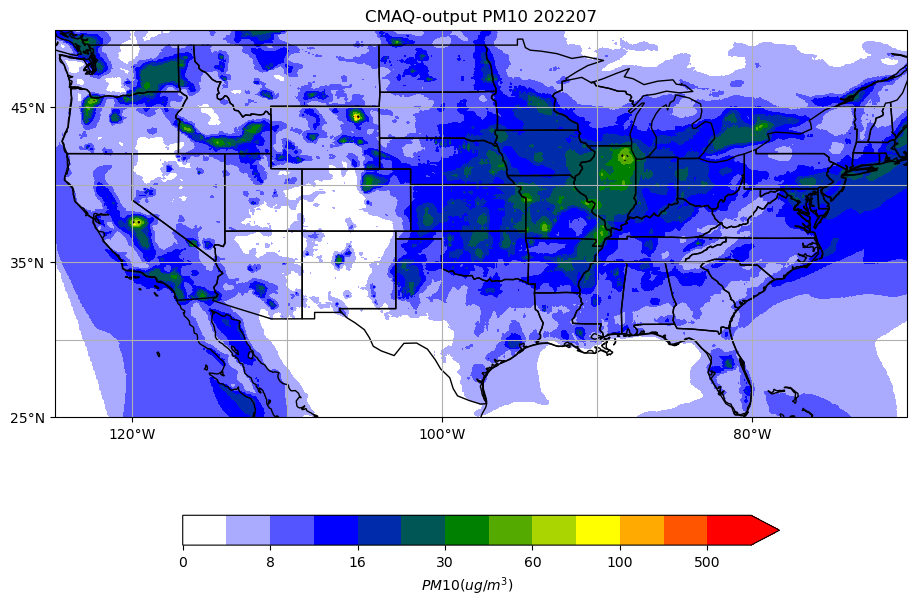

In [11]:
import matplotlib.colors as colors
import cartopy.feature as cfeature

# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
#ax=plt.axes(projection=ccrs.Robinson())


# Make a filled contour plot
vmin = 0
vmax = 100

from matplotlib.cm import ScalarMappable
levels = 400

level_boundaries = np.linspace(vmin, vmax, levels + 1)

clevs = [0,4,8,12,16,20,30,40,60,80,100,200,500,1000]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=13)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))

cs = ax.contourf(
            ds['lon'], ds['lat'], ds_daily['PM10'][:,:],
            clevs,
            cmap = colormap,
            norm = norm,
            extend='max',
            transform = ccrs.PlateCarree(),
            )
# Overlay of stippling
ss = ax.contourf(
            ds['lon'], ds['lat'], ds_daily['PM10'],[0,50],
            transform = ccrs.PlateCarree(),colors=['None'],
            hatches=['...',''],extend='both',alpha=0.0
            )

# Plot settings
lon1 = -125
lon2 = -70
lat1 = 25
lat2 = 50
plot_setting(ax, lon1, lon2, lat1, lat2)

# Define the xticks for longitude and yticks for latitude
lons = np.arange(-120,-69,20)
lats = np.arange(25,51,10)
xyticks(ax, lons, lats)

# Add colorbar
cbar = plt.colorbar(
            cs,
            shrink=0.7,
            orientation='horizontal',
            label='$PM10 (ug/m^{3})$',
            #ticks=range(vmin, vmax+10, 10),
            #boundaries=level_boundaries
            ) 
# Add title
plt.title('CMAQ-output PM10 202207')
;

''

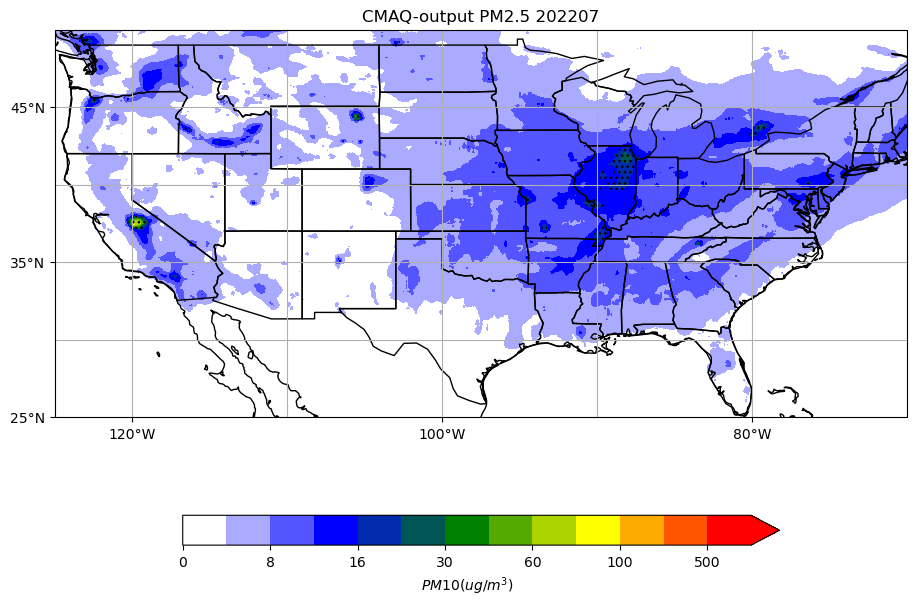

In [12]:
import matplotlib.colors as colors
import cartopy.feature as cfeature

# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
#ax=plt.axes(projection=ccrs.Robinson())


# Make a filled contour plot
vmin = 0
vmax = 100

from matplotlib.cm import ScalarMappable
levels = 400

level_boundaries = np.linspace(vmin, vmax, levels + 1)

clevs = [0,4,8,12,16,20,30,40,60,80,100,200,500,1000]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=13)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))

cs = ax.contourf(
            ds['lon'], ds['lat'], ds_daily['PM25'][:,:],
            clevs,
            cmap = colormap,
            norm = norm,
            extend='max',
            transform = ccrs.PlateCarree(),
            )
# Overlay of stippling
ss = ax.contourf(
            ds['lon'], ds['lat'], ds_daily['PM25'],[0,15],
            transform = ccrs.PlateCarree(),colors=['None'],
            hatches=['...',''],extend='both',alpha=0.0
            )
# Plot settings
lon1 = -125
lon2 = -70
lat1 = 25
lat2 = 50
plot_setting(ax, lon1, lon2, lat1, lat2)

# Define the xticks for longitude and yticks for latitude
lons = np.arange(-120,-69,20)
lats = np.arange(25,51,10)
xyticks(ax, lons, lats)

# Add colorbar
cbar = plt.colorbar(
            cs,
            shrink=0.7,
            orientation='horizontal',
            label='$PM10 (ug/m^{3})$',
            #ticks=range(vmin, vmax+10, 10),
            #boundaries=level_boundaries
            ) 
# Add title
plt.title('CMAQ-output PM2.5 202207')
;

''

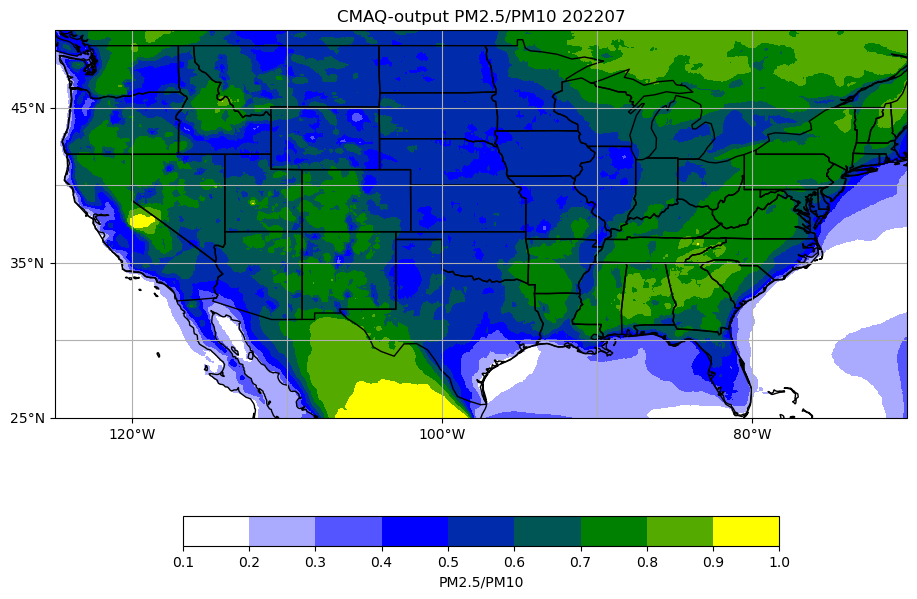

In [13]:
import matplotlib.colors as colors
import cartopy.feature as cfeature

# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
#ax=plt.axes(projection=ccrs.Robinson())


# Make a filled contour plot
vmin = 0
vmax = 100

from matplotlib.cm import ScalarMappable
levels = 400

level_boundaries = np.linspace(vmin, vmax, levels + 1)

clevs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=13)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))

cs = ax.contourf(
            ds['lon'], ds['lat'], ds_daily['PM25']/ds_daily['PM10'],
            clevs,
            cmap = colormap,
            norm = norm,
            #extend='max',
            transform = ccrs.PlateCarree(),
            )
# Plot settings
lon1 = -125
lon2 = -70
lat1 = 25
lat2 = 50
plot_setting(ax, lon1, lon2, lat1, lat2)

# Define the xticks for longitude and yticks for latitude
lons = np.arange(-120,-69,20)
lats = np.arange(25,51,10)
xyticks(ax, lons, lats)

# Add colorbar
cbar = plt.colorbar(
            cs,
            shrink=0.7,
            orientation='horizontal',
            label='PM2.5/PM10',
            #ticks=range(vmin, vmax+10, 10),
            #boundaries=level_boundaries
            ) 
# Add title
plt.title('CMAQ-output PM2.5/PM10 202207')
;

In [14]:
path = '/home/cshu2/clim680/'
fname1 = 'newPM_202201.nc'
ds1 = xr.open_dataset(path+fname1)
ds1

<xarray.Dataset>
Dimensions:  (day: 31, time: 24, lat: 351, lon: 801)
Coordinates:
  * day      (day) int32 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
  * time     (time) int32 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
  * lat      (lat) float32 15.0 15.1 15.2 15.3 15.4 ... 49.6 49.7 49.8 49.9 50.0
  * lon      (lon) float32 -130.0 -129.9 -129.8 -129.7 ... -50.2 -50.1 -50.0
Data variables:
    PM10     (day, time, lat, lon) float32 ...
    PM25     (day, time, lat, lon) float32 ...

In [15]:
ds_climo1 = ds1.groupby('time').mean('day')
ds_climo1

<xarray.Dataset>
Dimensions:  (time: 24, lat: 351, lon: 801)
Coordinates:
  * time     (time) int32 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
  * lat      (lat) float32 15.0 15.1 15.2 15.3 15.4 ... 49.6 49.7 49.8 49.9 50.0
  * lon      (lon) float32 -130.0 -129.9 -129.8 -129.7 ... -50.2 -50.1 -50.0
Data variables:
    PM10     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    PM25     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [16]:
ds_daily1 = ds_climo1.groupby('lat').mean('time')
ds_daily1

<xarray.Dataset>
Dimensions:  (lat: 351, lon: 801)
Coordinates:
  * lat      (lat) float32 15.0 15.1 15.2 15.3 15.4 ... 49.6 49.7 49.8 49.9 50.0
  * lon      (lon) float32 -130.0 -129.9 -129.8 -129.7 ... -50.2 -50.1 -50.0
Data variables:
    PM10     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    PM25     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [17]:
import matplotlib.colors as colors
import cartopy.feature as cfeature
import matplotlib

# Make the figure larger
fig = plt.figure(figsize=(11,6.5))

from matplotlib.cm import ScalarMappable

clevs = [0,4,8,12,16,20,30,40,60,80,100,200,500,1000]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=13)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))



<Figure size 1100x650 with 0 Axes>

Text(0.5, 0.98, 'CMAQ-output PM10 202201 monthly diurnal mean')

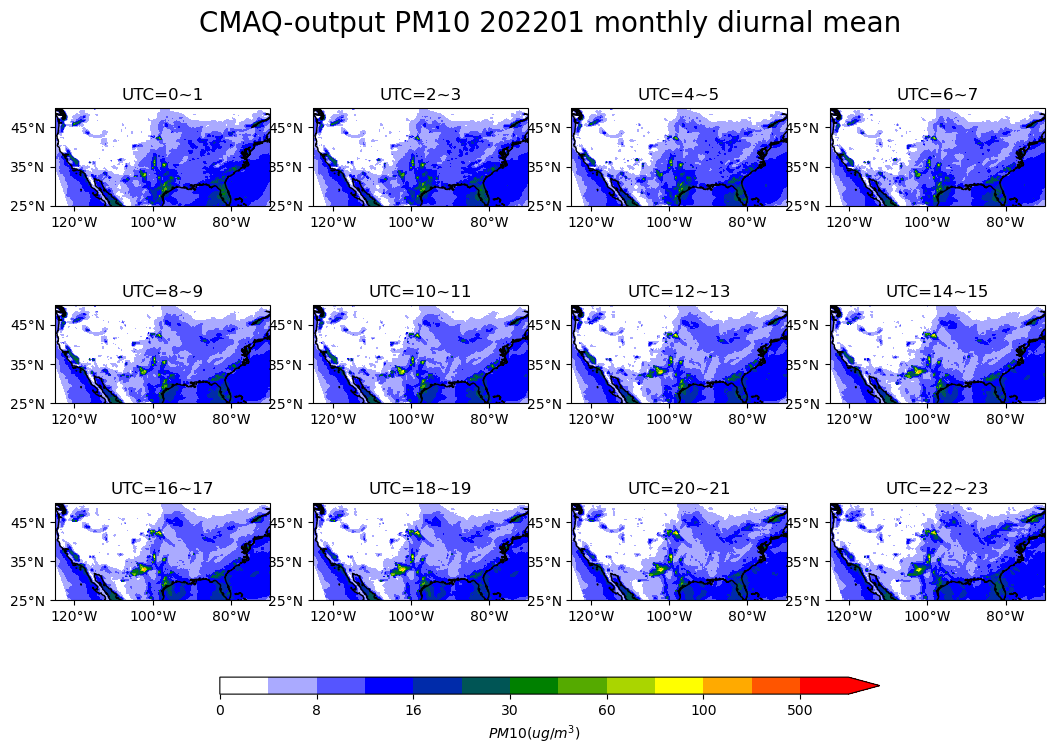

In [18]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=3,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i in range(0,12,1):

        # Contour plot
        cs=axs[i].contourf(            
            ds_climo1['lon'], 
            ds_climo1['lat'], 
            (ds_climo1['PM10'][i,:,:]+ds_climo1['PM10'][i+1,:,:])/2,
            clevs,
            cmap = colormap,
            norm = norm,
            extend='max',
            transform = ccrs.PlateCarree(),
        )
        # Choose lat/lon ranges
        axs[i].set_extent([-125,-70,25,50],crs=ccrs.PlateCarree())
       # Longitude labels
        axs[i].set_xticks(np.arange(-120,-69,20), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(25,51,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the time
        title = f"UTC={2*i}~{2*i+1}"
        axs[i].set_title(title)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25) #width and height

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$PM10 (ug/m^{3})$')

# Add a big title at the top
plt.suptitle('CMAQ-output PM10 202201 monthly diurnal mean',fontsize=20)

Text(0.5, 0.98, 'CMAQ-output PM2.5/PM10 ratio 202201 monthly diurnal mean')

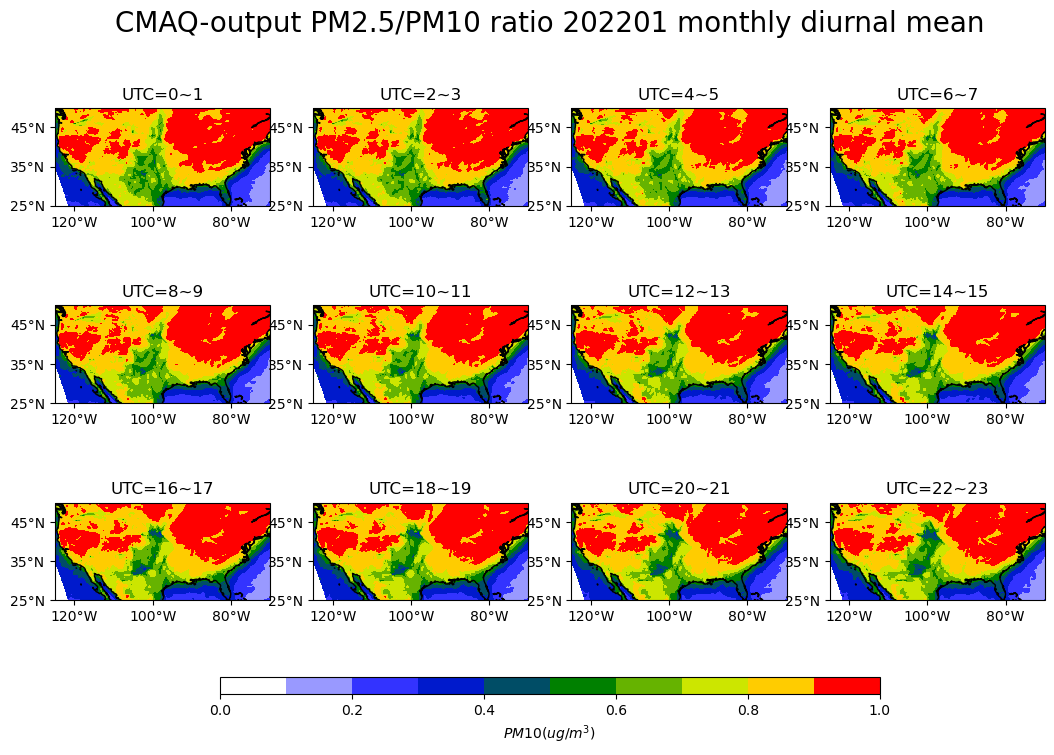

In [19]:
clevs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=11)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))

# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=3,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i in range(0,12,1):

        # Contour plot
        cs=axs[i].contourf(            
            ds_climo1['lon'], 
            ds_climo1['lat'], 
            (ds_climo1['PM25'][i,:,:]+ds_climo1['PM25'][i+1,:,:])/(ds_climo1['PM10'][i,:,:]+ds_climo1['PM10'][i+1,:,:]),
            clevs,
            cmap = colormap,
            norm = norm,
            #extend='max',
            transform = ccrs.PlateCarree(),
        )
        # Choose lat/lon ranges
        axs[i].set_extent([-125,-70,25,50],crs=ccrs.PlateCarree())
       # Longitude labels
        axs[i].set_xticks(np.arange(-120,-69,20), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(25,51,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the time
        title = f"UTC={2*i}~{2*i+1}"
        axs[i].set_title(title)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25) #width and height

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='$PM10 (ug/m^{3})$')

# Add a big title at the top
plt.suptitle('CMAQ-output PM2.5/PM10 ratio 202201 monthly diurnal mean',fontsize=20)

''

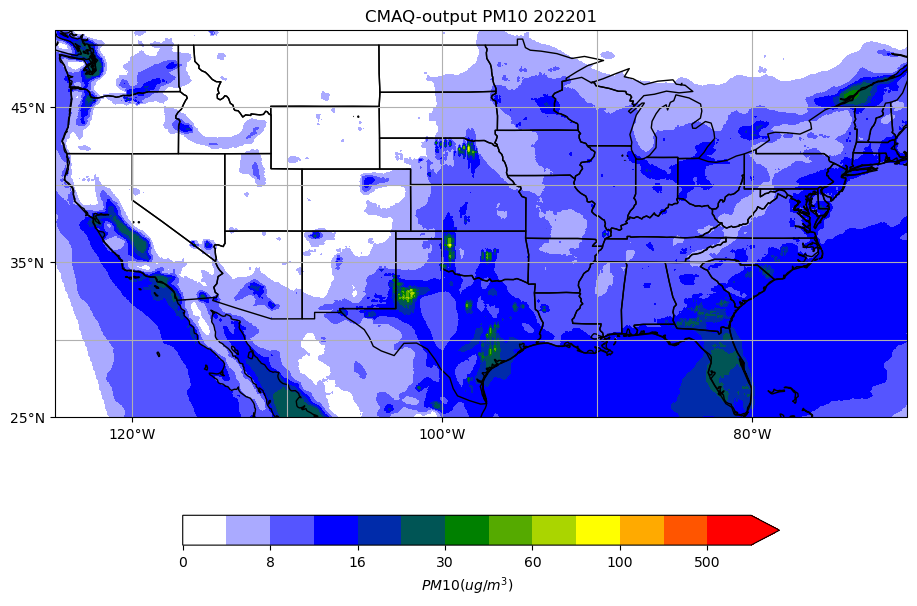

In [20]:
import matplotlib.colors as colors
import cartopy.feature as cfeature

# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
#ax=plt.axes(projection=ccrs.Robinson())


# Make a filled contour plot
vmin = 0
vmax = 100

from matplotlib.cm import ScalarMappable
levels = 400

level_boundaries = np.linspace(vmin, vmax, levels + 1)

clevs = [0,4,8,12,16,20,30,40,60,80,100,200,500,1000]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=13)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))

cs = ax.contourf(
            ds1['lon'], ds1['lat'], ds_daily1['PM10'][:,:],
            clevs,
            cmap = colormap,
            norm = norm,
            extend='max',
            transform = ccrs.PlateCarree(),
            )
# Overlay of stippling
ss = ax.contourf(
            ds['lon'], ds['lat'], ds_daily['PM10'],[0,50],
            transform = ccrs.PlateCarree(),colors=['None'],
            hatches=['...',''],extend='both',alpha=0.0
            )

# Plot settings
lon1 = -125
lon2 = -70
lat1 = 25
lat2 = 50
plot_setting(ax, lon1, lon2, lat1, lat2)

# Define the xticks for longitude and yticks for latitude
lons = np.arange(-120,-69,20)
lats = np.arange(25,51,10)
xyticks(ax, lons, lats)

# Add colorbar
cbar = plt.colorbar(
            cs,
            shrink=0.7,
            orientation='horizontal',
            label='$PM10 (ug/m^{3})$',
            #ticks=range(vmin, vmax+10, 10),
            #boundaries=level_boundaries
            ) 
# Add title
plt.title('CMAQ-output PM10 202201')
;

''

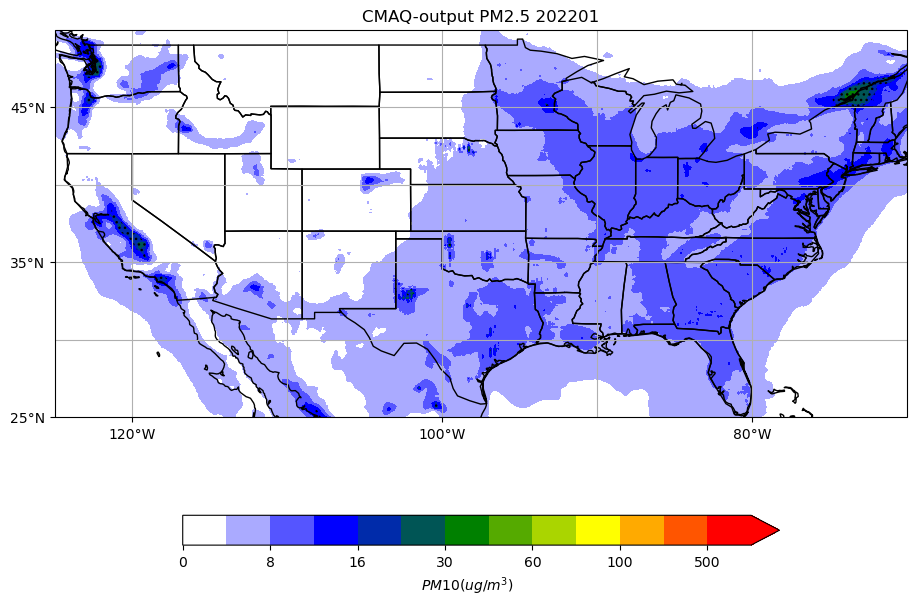

In [21]:
import matplotlib.colors as colors
import cartopy.feature as cfeature

# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
#ax=plt.axes(projection=ccrs.Robinson())


# Make a filled contour plot
vmin = 0
vmax = 100

from matplotlib.cm import ScalarMappable
levels = 400

level_boundaries = np.linspace(vmin, vmax, levels + 1)

clevs = [0,4,8,12,16,20,30,40,60,80,100,200,500,1000]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=13)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))

cs = ax.contourf(
            ds1['lon'], ds1['lat'], ds_daily1['PM25'][:,:],
            clevs,
            cmap = colormap,
            norm = norm,
            extend='max',
            transform = ccrs.PlateCarree(),
            )
# Overlay of stippling
ss = ax.contourf(
            ds1['lon'], ds1['lat'], ds_daily1['PM25'],[0,15],
            transform = ccrs.PlateCarree(),colors=['None'],
            hatches=['...',''],extend='both',alpha=0.0
            )

# Plot settings
lon1 = -125
lon2 = -70
lat1 = 25
lat2 = 50
plot_setting(ax, lon1, lon2, lat1, lat2)

# Define the xticks for longitude and yticks for latitude
lons = np.arange(-120,-69,20)
lats = np.arange(25,51,10)
xyticks(ax, lons, lats)

# Add colorbar
cbar = plt.colorbar(
            cs,
            shrink=0.7,
            orientation='horizontal',
            label='$PM10 (ug/m^{3})$',
            #ticks=range(vmin, vmax+10, 10),
            #boundaries=level_boundaries
            ) 
# Add title
plt.title('CMAQ-output PM2.5 202201')
;

''

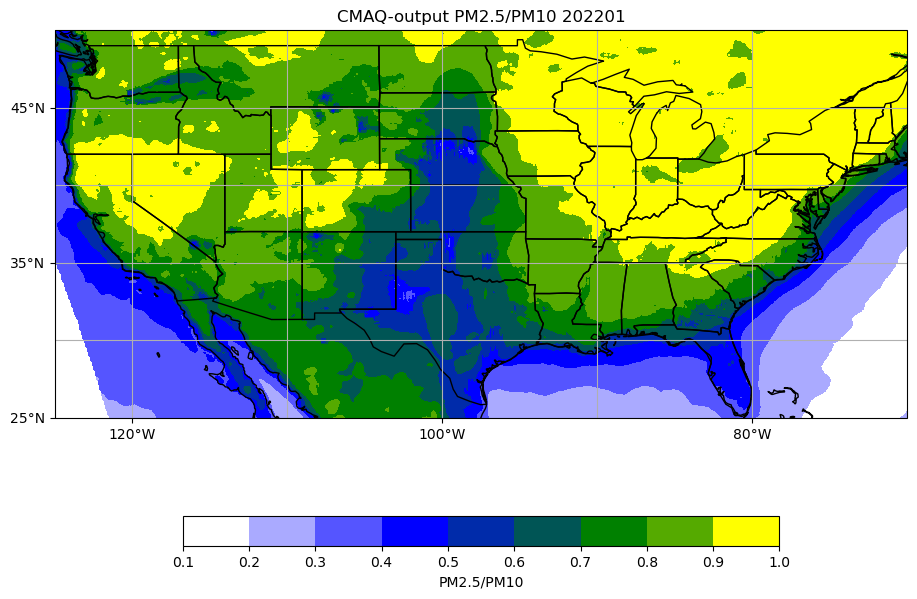

In [22]:
import matplotlib.colors as colors
import cartopy.feature as cfeature

# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
#ax=plt.axes(projection=ccrs.Robinson())


# Make a filled contour plot
vmin = 0
vmax = 100

from matplotlib.cm import ScalarMappable
levels = 400

level_boundaries = np.linspace(vmin, vmax, levels + 1)

clevs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colorslist = ['white','blue','green','yellow','red']
colormap = colors.LinearSegmentedColormap.from_list('123',colorslist,N=13)

norm = matplotlib.colors.BoundaryNorm(clevs,len(clevs))

cs = ax.contourf(
            ds1['lon'], ds1['lat'], ds_daily1['PM25']/ds_daily1['PM10'],
            clevs,
            cmap = colormap,
            norm = norm,
            #extend='max',
            transform = ccrs.PlateCarree(),
            )

# Plot settings
lon1 = -125
lon2 = -70
lat1 = 25
lat2 = 50
plot_setting(ax, lon1, lon2, lat1, lat2)

# Define the xticks for longitude and yticks for latitude
lons = np.arange(-120,-69,20)
lats = np.arange(25,51,10)
xyticks(ax, lons, lats)

# Add colorbar
cbar = plt.colorbar(
            cs,
            shrink=0.7,
            orientation='horizontal',
            label='PM2.5/PM10',
            #ticks=range(vmin, vmax+10, 10),
            #boundaries=level_boundaries
            ) 
# Add title
plt.title('CMAQ-output PM2.5/PM10 202201')
;